In [1]:
!pip install ax-platform textblob

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import re
import string
from textblob import Word
import nltk

import itertools
from collections import defaultdict

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from ax.api.client import Client
from ax.api.configs import ChoiceParameterConfig, RangeParameterConfig

[WARNING 12-15 01:55:19] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.


In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
data = pd.read_csv('/content/drive/MyDrive/Colab Data/CSC705_Project/AVC_claims_survey.sql.csv', dtype={'comments': str})

In [6]:
# Randomly reorder the DataFrame
data = data.sample(frac=1).reset_index(drop=True)
satisfied = data['satisfied']


# Convert the pandas Series y to a torch LongTensor
y_tensor = torch.tensor(satisfied.values, dtype=torch.long)

# Perform one-hot encoding. Since labels are 1-5, we need 6 classes (0-5) to accommodate.
# Then, we'll remove the first column (index 0) which corresponds to a non-existent class.
satisfied_oh = F.one_hot(y_tensor, num_classes=6)[:, 1:]

In [7]:
neg_labels = satisfied_oh[:, 0] + satisfied_oh[:, 1]
neu_labels = satisfied_oh[:, 2]
pos_labels = satisfied_oh[:, 3] + satisfied_oh[:, 4]

satisfied_3labels = torch.stack([neg_labels, neu_labels, pos_labels], dim=1)

print(f"Original satisfied_oh shape: {satisfied_oh.shape}")
print(f"New satisfied_3labels shape: {satisfied_3labels.shape}")

Original satisfied_oh shape: torch.Size([10699, 5])
New satisfied_3labels shape: torch.Size([10699, 3])


In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
data['comments'] = data['comments'].astype(str).fillna('')
# Split on any character that is NOT a word character (alphanumeric) or is an underscore.
# This effectively isolates all punctuation and symbols.
pattern = r'(\W|_)'
comments = [re.split(pattern, text.lower()) for text in data['comments']]
comments = [
    [item.strip() for item in sublist if item.strip()]
    for sublist in comments
]
comments = [
    [Word(item).lemmatize() for item in sublist]
    for sublist in comments
]

In [10]:
# Display unique tokens to verify separation
all_words = sorted(set(list(itertools.chain.from_iterable(comments))))

In [11]:
vocab = {i:t for i, t in enumerate(all_words)}
lookup = {token:integer for integer,token in vocab.items()}

In [12]:
encoded = [
    [lookup[token] for token in comment]
    for comment in comments
]
print([e[:5] for e in encoded])

[[7327, 1031, 7, 6199, 4741], [7690, 7640, 10645, 11764, 3187], [7327, 2522, 8997, 11444, 2893], [10645, 4651, 1504, 10645, 1993], [10645, 1331, 8529, 7685, 1195], [5553, 11444, 11358, 8140, 11691], [7327, 4580, 5638, 11602, 5553], [5553, 5161, 10785, 4937, 1], [7327, 2522, 11444, 4668, 11301], [4216, 11444, 5346, 1205, 4201], [5553, 5279, 7545, 11844, 5161], [10628, 11856, 4668, 11861, 9648], [10645, 8401, 9068, 11, 6288], [5997, 5983, 6160, 9976, 10639], [5553, 5161, 800, 11358, 9494], [11861, 10115, 3034, 6, 10473], [11528, 5279, 1952, 7770, 5495], [62, 8, 5553, 8686, 800], [5553, 6687, 11861, 11391, 8379], [5553, 10083, 11691, 7327, 1031], [7798, 788, 5079, 10393, 13], [10664, 5983, 7569, 1195, 5991], [5553, 11444, 11358, 5636, 5499], [5553, 2235, 9484, 4097, 5012], [9952, 8570, 5201, 7327, 2522], [10645, 8342, 11444, 9943, 3941], [1504, 10754, 5997, 11444, 10838], [5561, 11, 10645, 2914, 1326], [5553, 5997, 5983, 5234, 10785], [4218, 11568, 9925, 11691, 9382], [10645, 11629, 8341,

In [13]:
encoded = [torch.LongTensor(e) for e in encoded]

In [14]:
from sklearn.model_selection import train_test_split

# Split the encoded comments and satisfied_oh labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    encoded, satisfied_oh, test_size=0.2, random_state=42
)

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    encoded, satisfied_3labels, test_size=0.2, random_state=42
)

print(f"Training comments size: {len(X_train)}")
print(f"Testing comments size: {len(X_test)}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training comments size: 8559
Testing comments size: 2140
Training labels shape: torch.Size([8559, 5])
Testing labels shape: torch.Size([2140, 5])


In [15]:
class TextDataset(Dataset):
    def __init__(self, encoded_texts, labels):
        # Use clone().detach() to avoid UserWarning when creating tensor from tensor
        self.encodings = [seq.clone().detach().to(dtype=torch.long) for seq in encoded_texts]
        self.labels = labels.clone().detach().to(dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.encodings[idx], self.labels[idx]

In [16]:
def collate_batch(batch):
    texts, labels = zip(*batch)
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=0)
    return padded_texts, torch.stack(labels)

In [17]:
class SentimentTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, num_classes, max_len=512, dropout=0.1):
        super(SentimentTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # Simple learnable positional encoding
        self.pos_encoder = nn.Parameter(torch.randn(1, max_len, embed_dim))

        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embed_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # x shape: (batch_size, seq_len)
        seq_len = x.size(1)

        x = self.embedding(x) + self.pos_encoder[:, :seq_len, :]
        x = self.dropout(x)

        x = self.transformer_encoder(x, src_key_padding_mask=mask)

        x = x.mean(dim=1)

        # Final classification layer
        logits = self.fc(x)
        return logits

In [18]:
#Ax configuration
client = Client()
parameters = [
    RangeParameterConfig(
        name="num_layers", parameter_type="int", bounds=(1, 5)
    ),
    ChoiceParameterConfig(
        name="learning_rate",
        parameter_type="float",
        values=(0.0001, 0.001, 0.01),
        is_ordered=True
    ),

    ChoiceParameterConfig(
        name="num_heads", parameter_type="int", values=(2, 4, 8, 16),
        is_ordered=True
    )
]

client.configure_experiment(parameters=parameters)

metric_name = "loss"
client.configure_optimization(objective=f"-{metric_name}")

In [19]:
embedding_dim = 64
num_layers = 1
output_size = 5
vocabulary_size = len(vocab)
learning_rate = 0.01

losses = defaultdict(list)

for i in range(10):
    trials = client.get_next_trials(max_trials=3)

    for trial_index, parameters in trials.items():
        # Note: hidden_size from parameters is currently ignored to ensure compatibility
        # with num_heads choices. We use fixed embedding_dim=64.
        # hidden_size = parameters["hidden_size"]
        num_layers = parameters["num_layers"]
        learning_rate = parameters["learning_rate"]
        num_heads = parameters["num_heads"]

        print("Hyperparameters: ", num_layers, learning_rate, num_heads)

        dataset = TextDataset(X_train, y_train)
        dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_batch)

        model = SentimentTransformer(len(vocab), embedding_dim, num_heads, num_layers, output_size).to(device)
        # Use BCEWithLogitsLoss to handle raw logits from the model
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        num_epochs = 3

        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            for batch_idx, (X, y) in enumerate(dataloader):
                # Truncate sequence length to max_len (512) to avoid position encoding mismatch
                if X.size(1) > 512:
                    X = X[:, :512]

                X = X.to(device)
                y = y.to(device)
                optimizer.zero_grad()
                outputs = model(X)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            losses[(i, trial_index, num_layers, learning_rate, num_heads)].append(total_loss)

            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

        print("Training completed.")

        # Set raw_data as a dictionary with metric names as keys and results as values
        raw_data = {metric_name: total_loss}

        # Complete the trial with the result
        client.complete_trial(trial_index=trial_index, raw_data=raw_data)

[INFO 12-15 01:55:27] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 12-15 01:55:27] ax.api.client: Generated new trial 0 with parameters {'num_layers': 3, 'learning_rate': 0.001, 'num_heads': 8} using GenerationNode CenterOfSearchSpace.
[INFO 12-15 01:55:27] ax.api.client: Generated new trial 1 with parameters {'num_layers': 3, 'learning_rate': 0.0001, 'num_heads': 4} using GenerationNode Sobol.
[INFO 12-15 01:55:27] ax.api.client: Generated new trial 2 with parameters {'num_layers': 1, 'learning_rate': 0.01, 'num_heads': 8} using Gener

Hyperparameters:  3 0.001 8
Epoch [1/3], Loss: 1555.1753
Epoch [2/3], Loss: 1509.3940


[INFO 12-15 01:57:13] ax.api.client: Trial 0 marked COMPLETED.


Epoch [3/3], Loss: 1594.0195
Training completed.
Hyperparameters:  3 0.0001 4
Epoch [1/3], Loss: 1504.2108
Epoch [2/3], Loss: 1385.3965


[INFO 12-15 01:58:59] ax.api.client: Trial 1 marked COMPLETED.


Epoch [3/3], Loss: 1329.9949
Training completed.
Hyperparameters:  1 0.01 8
Epoch [1/3], Loss: 1532.4671
Epoch [2/3], Loss: 1451.7379


[INFO 12-15 01:59:49] ax.api.client: Trial 2 marked COMPLETED.
[INFO 12-15 01:59:49] ax.api.client: Generated new trial 3 with parameters {'num_layers': 3, 'learning_rate': 0.001, 'num_heads': 2} using GenerationNode Sobol.
[INFO 12-15 01:59:49] ax.api.client: Generated new trial 4 with parameters {'num_layers': 5, 'learning_rate': 0.001, 'num_heads': 16} using GenerationNode Sobol.
[WARNING 12-15 01:59:49] ax.api.client: 3 trials requested but only 2 could be generated.


Epoch [3/3], Loss: 1374.6660
Training completed.
Hyperparameters:  3 0.001 2
Epoch [1/3], Loss: 1650.0518
Epoch [2/3], Loss: 1602.3002


[INFO 12-15 02:01:36] ax.api.client: Trial 3 marked COMPLETED.


Epoch [3/3], Loss: 1574.6884
Training completed.
Hyperparameters:  5 0.001 16
Epoch [1/3], Loss: 1663.9961
Epoch [2/3], Loss: 1656.0742


[INFO 12-15 02:04:21] ax.api.client: Trial 4 marked COMPLETED.


Epoch [3/3], Loss: 1654.5827
Training completed.


[INFO 12-15 02:04:21] ax.api.client: Generated new trial 5 with parameters {'num_layers': 1, 'learning_rate': 0.0001, 'num_heads': 16} using GenerationNode MBM.
[WARNING 12-15 02:04:21] ax.api.client: 3 trials requested but only 1 could be generated.


Hyperparameters:  1 0.0001 16
Epoch [1/3], Loss: 1529.1850
Epoch [2/3], Loss: 1383.5049


[INFO 12-15 02:05:11] ax.api.client: Trial 5 marked COMPLETED.


Epoch [3/3], Loss: 1324.1570
Training completed.


[INFO 12-15 02:05:11] ax.api.client: Generated new trial 6 with parameters {'num_layers': 1, 'learning_rate': 0.0001, 'num_heads': 2} using GenerationNode MBM.
[INFO 12-15 02:05:11] ax.api.client: Generated new trial 7 with parameters {'num_layers': 5, 'learning_rate': 0.0001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-15 02:05:11] ax.api.client: Generated new trial 8 with parameters {'num_layers': 5, 'learning_rate': 0.01, 'num_heads': 2} using GenerationNode MBM.


Hyperparameters:  1 0.0001 2
Epoch [1/3], Loss: 1509.0786
Epoch [2/3], Loss: 1388.4551


[INFO 12-15 02:06:01] ax.api.client: Trial 6 marked COMPLETED.


Epoch [3/3], Loss: 1340.0950
Training completed.
Hyperparameters:  5 0.0001 16
Epoch [1/3], Loss: 1532.7475
Epoch [2/3], Loss: 1418.4967


[INFO 12-15 02:08:47] ax.api.client: Trial 7 marked COMPLETED.


Epoch [3/3], Loss: 1387.0759
Training completed.
Hyperparameters:  5 0.01 2
Epoch [1/3], Loss: 1681.6379
Epoch [2/3], Loss: 1665.1127


[INFO 12-15 02:11:32] ax.api.client: Trial 8 marked COMPLETED.


Epoch [3/3], Loss: 1660.3582
Training completed.


[INFO 12-15 02:11:32] ax.api.client: Generated new trial 9 with parameters {'num_layers': 2, 'learning_rate': 0.0001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-15 02:11:32] ax.api.client: Generated new trial 10 with parameters {'num_layers': 2, 'learning_rate': 0.0001, 'num_heads': 2} using GenerationNode MBM.
[INFO 12-15 02:11:32] ax.api.client: Generated new trial 11 with parameters {'num_layers': 3, 'learning_rate': 0.0001, 'num_heads': 2} using GenerationNode MBM.


Hyperparameters:  2 0.0001 16
Epoch [1/3], Loss: 1504.3546
Epoch [2/3], Loss: 1375.7632


[INFO 12-15 02:12:50] ax.api.client: Trial 9 marked COMPLETED.


Epoch [3/3], Loss: 1328.0872
Training completed.
Hyperparameters:  2 0.0001 2
Epoch [1/3], Loss: 1506.4230
Epoch [2/3], Loss: 1392.7382


[INFO 12-15 02:14:10] ax.api.client: Trial 10 marked COMPLETED.


Epoch [3/3], Loss: 1341.7301
Training completed.
Hyperparameters:  3 0.0001 2
Epoch [1/3], Loss: 1495.6157
Epoch [2/3], Loss: 1374.4931


[INFO 12-15 02:15:59] ax.api.client: Trial 11 marked COMPLETED.


Epoch [3/3], Loss: 1332.5617
Training completed.


[INFO 12-15 02:15:59] ax.api.client: Generated new trial 12 with parameters {'num_layers': 3, 'learning_rate': 0.0001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-15 02:15:59] ax.api.client: Generated new trial 13 with parameters {'num_layers': 4, 'learning_rate': 0.0001, 'num_heads': 2} using GenerationNode MBM.
[INFO 12-15 02:15:59] ax.api.client: Generated new trial 14 with parameters {'num_layers': 1, 'learning_rate': 0.01, 'num_heads': 2} using GenerationNode MBM.


Hyperparameters:  3 0.0001 16
Epoch [1/3], Loss: 1503.3323
Epoch [2/3], Loss: 1377.1370


[INFO 12-15 02:17:46] ax.api.client: Trial 12 marked COMPLETED.


Epoch [3/3], Loss: 1326.6141
Training completed.
Hyperparameters:  4 0.0001 2
Epoch [1/3], Loss: 1496.2284
Epoch [2/3], Loss: 1395.2521


[INFO 12-15 02:20:02] ax.api.client: Trial 13 marked COMPLETED.


Epoch [3/3], Loss: 1359.7007
Training completed.
Hyperparameters:  1 0.01 2
Epoch [1/3], Loss: 1560.7338
Epoch [2/3], Loss: 1479.7238


[INFO 12-15 02:20:52] ax.api.client: Trial 14 marked COMPLETED.


Epoch [3/3], Loss: 1402.6421
Training completed.


[INFO 12-15 02:20:53] ax.api.client: Generated new trial 15 with parameters {'num_layers': 2, 'learning_rate': 0.0001, 'num_heads': 8} using GenerationNode MBM.
[INFO 12-15 02:20:53] ax.api.client: Generated new trial 16 with parameters {'num_layers': 2, 'learning_rate': 0.0001, 'num_heads': 4} using GenerationNode MBM.
[INFO 12-15 02:20:53] ax.api.client: Generated new trial 17 with parameters {'num_layers': 1, 'learning_rate': 0.0001, 'num_heads': 4} using GenerationNode MBM.


Hyperparameters:  2 0.0001 8
Epoch [1/3], Loss: 1509.2339
Epoch [2/3], Loss: 1374.8525


[INFO 12-15 02:22:12] ax.api.client: Trial 15 marked COMPLETED.


Epoch [3/3], Loss: 1317.0451
Training completed.
Hyperparameters:  2 0.0001 4
Epoch [1/3], Loss: 1517.1717
Epoch [2/3], Loss: 1380.3447


[INFO 12-15 02:23:30] ax.api.client: Trial 16 marked COMPLETED.


Epoch [3/3], Loss: 1341.7237
Training completed.
Hyperparameters:  1 0.0001 4
Epoch [1/3], Loss: 1510.3546
Epoch [2/3], Loss: 1384.5062


[INFO 12-15 02:24:20] ax.api.client: Trial 17 marked COMPLETED.


Epoch [3/3], Loss: 1339.7017
Training completed.


[INFO 12-15 02:24:21] ax.api.client: Generated new trial 18 with parameters {'num_layers': 3, 'learning_rate': 0.0001, 'num_heads': 8} using GenerationNode MBM.
[INFO 12-15 02:24:21] ax.api.client: Generated new trial 19 with parameters {'num_layers': 1, 'learning_rate': 0.0001, 'num_heads': 8} using GenerationNode MBM.
[INFO 12-15 02:24:21] ax.api.client: Generated new trial 20 with parameters {'num_layers': 4, 'learning_rate': 0.0001, 'num_heads': 16} using GenerationNode MBM.


Hyperparameters:  3 0.0001 8
Epoch [1/3], Loss: 1511.6707
Epoch [2/3], Loss: 1385.0682


[INFO 12-15 02:26:08] ax.api.client: Trial 18 marked COMPLETED.


Epoch [3/3], Loss: 1339.5051
Training completed.
Hyperparameters:  1 0.0001 8
Epoch [1/3], Loss: 1512.6926
Epoch [2/3], Loss: 1382.7551


[INFO 12-15 02:26:57] ax.api.client: Trial 19 marked COMPLETED.


Epoch [3/3], Loss: 1327.2335
Training completed.
Hyperparameters:  4 0.0001 16
Epoch [1/3], Loss: 1512.2635
Epoch [2/3], Loss: 1388.2123


[INFO 12-15 02:29:13] ax.api.client: Trial 20 marked COMPLETED.


Epoch [3/3], Loss: 1335.7788
Training completed.


[INFO 12-15 02:29:13] ax.api.client: Generated new trial 21 with parameters {'num_layers': 4, 'learning_rate': 0.0001, 'num_heads': 8} using GenerationNode MBM.
[INFO 12-15 02:29:13] ax.api.client: Generated new trial 22 with parameters {'num_layers': 4, 'learning_rate': 0.0001, 'num_heads': 4} using GenerationNode MBM.
[INFO 12-15 02:29:13] ax.api.client: Generated new trial 23 with parameters {'num_layers': 1, 'learning_rate': 0.01, 'num_heads': 16} using GenerationNode MBM.


Hyperparameters:  4 0.0001 8
Epoch [1/3], Loss: 1514.0700
Epoch [2/3], Loss: 1379.2395


[INFO 12-15 02:31:30] ax.api.client: Trial 21 marked COMPLETED.


Epoch [3/3], Loss: 1326.9975
Training completed.
Hyperparameters:  4 0.0001 4
Epoch [1/3], Loss: 1501.5690
Epoch [2/3], Loss: 1381.0988


[INFO 12-15 02:33:46] ax.api.client: Trial 22 marked COMPLETED.


Epoch [3/3], Loss: 1335.5568
Training completed.
Hyperparameters:  1 0.01 16
Epoch [1/3], Loss: 1495.7243
Epoch [2/3], Loss: 1345.7517


[INFO 12-15 02:34:36] ax.api.client: Trial 23 marked COMPLETED.


Epoch [3/3], Loss: 1273.2638
Training completed.


[INFO 12-15 02:34:36] ax.api.client: Generated new trial 24 with parameters {'num_layers': 3, 'learning_rate': 0.01, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-15 02:34:36] ax.api.client: Generated new trial 25 with parameters {'num_layers': 2, 'learning_rate': 0.01, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-15 02:34:36] ax.api.client: Generated new trial 26 with parameters {'num_layers': 5, 'learning_rate': 0.01, 'num_heads': 16} using GenerationNode MBM.


Hyperparameters:  3 0.01 16
Epoch [1/3], Loss: 1682.2440
Epoch [2/3], Loss: 1664.4746


[INFO 12-15 02:36:25] ax.api.client: Trial 24 marked COMPLETED.


Epoch [3/3], Loss: 1661.8387
Training completed.
Hyperparameters:  2 0.01 16
Epoch [1/3], Loss: 1683.2041
Epoch [2/3], Loss: 1636.6664


[INFO 12-15 02:37:44] ax.api.client: Trial 25 marked COMPLETED.


Epoch [3/3], Loss: 1550.1206
Training completed.
Hyperparameters:  5 0.01 16
Epoch [1/3], Loss: 1680.5135
Epoch [2/3], Loss: 1666.8518


[INFO 12-15 02:40:29] ax.api.client: Trial 26 marked COMPLETED.


Epoch [3/3], Loss: 1663.0560
Training completed.


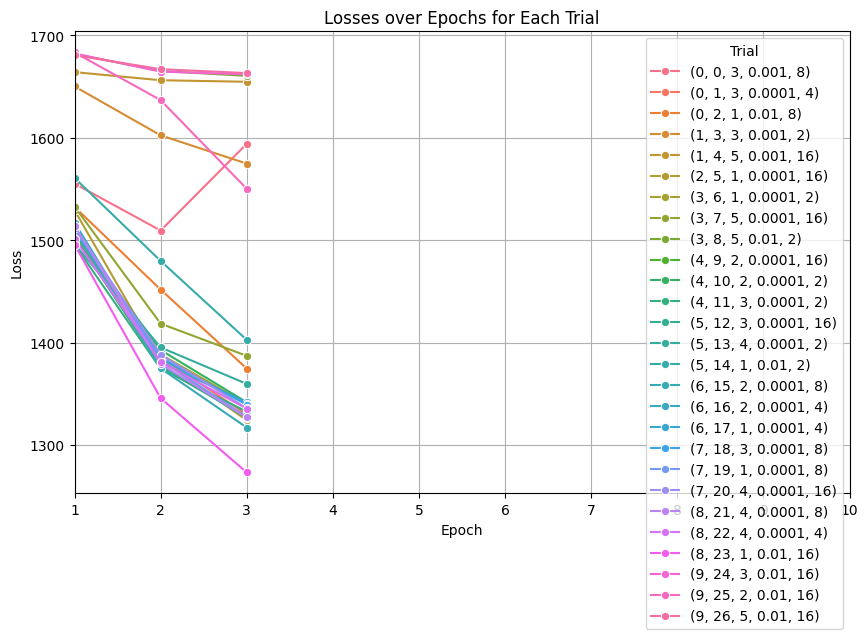

In [20]:
# Prepare data for plotting
plot_data = []
for trial_idx, trial_losses in losses.items():
    for epoch, loss_val in enumerate(trial_losses):
        plot_data.append({'Trial': trial_idx, 'Epoch': epoch + 1, 'Loss': loss_val})

df_losses = pd.DataFrame(plot_data)

# Plotting the losses
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_losses, x='Epoch', y='Loss', hue='Trial', marker='o')
plt.title('Losses over Epochs for Each Trial')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xlim(1, 10) # Set x-axis limit to 10 epochs
plt.show()

In [21]:
client.get_best_parameterization()

[WARNING 12-15 02:40:30] ax.adapter.cross_validation: Metric loss was unable to be reliably fit.
[WARNING 12-15 02:40:30] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 12-15 02:40:30] ax.service.utils.best_point: Model fit is poor and data on objective metric loss is noisy; interpret best points results carefully.


({'num_layers': 1, 'learning_rate': 0.01, 'num_heads': 16},
 {'loss': (1273.2638477552682, nan)},
 23,
 '23_0')

In [22]:
(best_parameters, loss, _, _) = client.get_best_parameterization()

print("Best Hyperparameters:")
for key, value in best_parameters.items():
    print(f"  {key}: {value}")

[WARNING 12-15 02:40:31] ax.adapter.cross_validation: Metric loss was unable to be reliably fit.
[WARNING 12-15 02:40:31] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 12-15 02:40:31] ax.service.utils.best_point: Model fit is poor and data on objective metric loss is noisy; interpret best points results carefully.


Best Hyperparameters:
  num_layers: 1
  learning_rate: 0.01
  num_heads: 16


In [23]:
embedding_dim = 64
hidden_size = 20
num_layers = 1
output_size = 5
vocabulary_size = len(vocab)
learning_rate = 0.01

num_layers = best_parameters["num_layers"]
learning_rate = best_parameters["learning_rate"]
num_heads = best_parameters["num_heads"]

dataset = TextDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_batch)

model = SentimentTransformer(vocabulary_size, embedding_dim, num_heads, num_layers, output_size).to(device)
# Use BCEWithLogitsLoss to handle raw logits from the model
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (X, y) in enumerate(dataloader):
        # Truncate sequence length to max_len (512) to avoid position encoding mismatch
        if X.size(1) > 512:
            X = X[:, :512]

        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses[(i, trial_index, num_layers, learning_rate, num_heads)].append(total_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

print("Training completed.")

# Set raw_data as a dictionary with metric names as keys and results as values
raw_data = {metric_name: total_loss}

Epoch [1/10], Loss: 1468.2356
Epoch [2/10], Loss: 1359.9272
Epoch [3/10], Loss: 1305.7042
Epoch [4/10], Loss: 1249.8108
Epoch [5/10], Loss: 1203.2444
Epoch [6/10], Loss: 1170.5573
Epoch [7/10], Loss: 1146.9000
Epoch [8/10], Loss: 1114.3480
Epoch [9/10], Loss: 1094.7296
Epoch [10/10], Loss: 1081.1803
Training completed.


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error

# Create DataLoader for test data
test_dataset = TextDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X, y in test_dataloader:
        # Truncate sequence length to max_len (512) to match training
        if X.size(1) > 512:
            X = X[:, :512]

        X = X.to(device)
        outputs = model(X)

        # Get predicted class indices (argmax of logits)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        # Get true class indices from one-hot encoded labels
        targets = torch.argmax(y, dim=1).numpy()

        all_preds.extend(preds)
        all_targets.extend(targets)

# Calculate metrics
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)
mae = mean_absolute_error(all_targets, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MAE: {mae:.4f}")

Accuracy: 0.6617
Precision: 0.5917
Recall: 0.6617
F1 Score: 0.6236
MAE: 0.5505


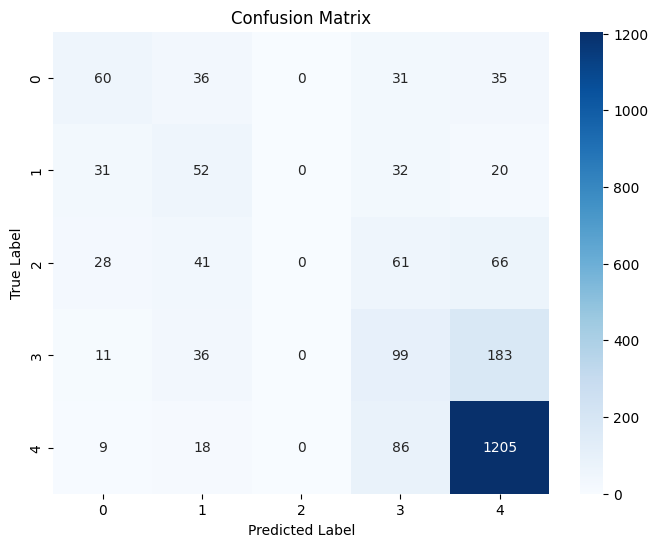

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [26]:
#Ax configuration
client = Client()
parameters = [
    RangeParameterConfig(
        name="num_layers", parameter_type="int", bounds=(1, 5)
    ),
    ChoiceParameterConfig(
        name="learning_rate",
        parameter_type="float",
        values=(0.0001, 0.001, 0.01),
        is_ordered=True
    ),

    ChoiceParameterConfig(
        name="num_heads", parameter_type="int", values=(2, 4, 8, 16),
        is_ordered=True
    )
]

client.configure_experiment(parameters=parameters)

metric_name = "loss"
client.configure_optimization(objective=f"-{metric_name}")

In [27]:
embedding_dim = 64
hidden_size = 20
num_layers = 1
output_size = 3
vocabulary_size = len(vocab)
learning_rate = 0.01

losses = defaultdict(list)

for i in range(10):
    trials = client.get_next_trials(max_trials=3)

    for trial_index, parameters in trials.items():
        # Note: hidden_size from parameters is currently ignored to ensure compatibility
        # with num_heads choices. We use fixed embedding_dim=64.
        # hidden_size = parameters["hidden_size"]
        num_layers = parameters["num_layers"]
        learning_rate = parameters["learning_rate"]
        num_heads = parameters["num_heads"]

        print("Hyperparameters: ", num_layers, learning_rate, num_heads)

        dataset = TextDataset(X_train3, y_train3)
        dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_batch)

        model = SentimentTransformer(len(vocab), embedding_dim, num_heads, num_layers, output_size).to(device)
        # Use BCEWithLogitsLoss to handle raw logits from the model
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        num_epochs = 3

        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            for batch_idx, (X, y) in enumerate(dataloader):
                # Truncate sequence length to max_len (512) to avoid position encoding mismatch
                if X.size(1) > 512:
                    X = X[:, :512]

                X = X.to(device)
                y = y.to(device)
                optimizer.zero_grad()
                outputs = model(X)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            losses[(i, trial_index, embedding_dim, num_layers, learning_rate, num_heads)].append(total_loss)

            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

        print("Training completed.")

        # Set raw_data as a dictionary with metric names as keys and results as values
        raw_data = {metric_name: total_loss}

        # Complete the trial with the result
        client.complete_trial(trial_index=trial_index, raw_data=raw_data)

[INFO 12-15 02:43:18] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 12-15 02:43:18] ax.api.client: Generated new trial 0 with parameters {'num_layers': 3, 'learning_rate': 0.001, 'num_heads': 8} using GenerationNode CenterOfSearchSpace.
[INFO 12-15 02:43:18] ax.api.client: Generated new trial 1 with parameters {'num_layers': 5, 'learning_rate': 0.0001, 'num_heads': 2} using GenerationNode Sobol.
[INFO 12-15 02:43:18] ax.api.client: Generated new trial 2 with parameters {'num_layers': 2, 'learning_rate': 0.01, 'num_heads': 16} using Gene

Hyperparameters:  3 0.001 8
Epoch [1/3], Loss: 1706.0256
Epoch [2/3], Loss: 1820.6196


[INFO 12-15 02:45:05] ax.api.client: Trial 0 marked COMPLETED.


Epoch [3/3], Loss: 1818.4088
Training completed.
Hyperparameters:  5 0.0001 2
Epoch [1/3], Loss: 1596.8146
Epoch [2/3], Loss: 1469.3290


[INFO 12-15 02:47:50] ax.api.client: Trial 1 marked COMPLETED.


Epoch [3/3], Loss: 1446.8154
Training completed.
Hyperparameters:  2 0.01 16
Epoch [1/3], Loss: 1846.8623
Epoch [2/3], Loss: 1651.5770


[INFO 12-15 02:49:09] ax.api.client: Trial 2 marked COMPLETED.
[INFO 12-15 02:49:09] ax.api.client: Generated new trial 3 with parameters {'num_layers': 1, 'learning_rate': 0.0001, 'num_heads': 4} using GenerationNode Sobol.
[INFO 12-15 02:49:09] ax.api.client: Generated new trial 4 with parameters {'num_layers': 3, 'learning_rate': 0.01, 'num_heads': 8} using GenerationNode Sobol.
[WARNING 12-15 02:49:09] ax.api.client: 3 trials requested but only 2 could be generated.


Epoch [3/3], Loss: 1591.0062
Training completed.
Hyperparameters:  1 0.0001 4
Epoch [1/3], Loss: 1547.7392
Epoch [2/3], Loss: 1373.1258


[INFO 12-15 02:49:59] ax.api.client: Trial 3 marked COMPLETED.


Epoch [3/3], Loss: 1319.5483
Training completed.
Hyperparameters:  3 0.01 8
Epoch [1/3], Loss: 1850.9451
Epoch [2/3], Loss: 1827.1652


[INFO 12-15 02:51:48] ax.api.client: Trial 4 marked COMPLETED.
[INFO 12-15 02:51:48] ax.api.client: Generated new trial 5 with parameters {'num_layers': 1, 'learning_rate': 0.01, 'num_heads': 2} using GenerationNode MBM.
[WARNING 12-15 02:51:48] ax.api.client: 3 trials requested but only 1 could be generated.


Epoch [3/3], Loss: 1823.5959
Training completed.
Hyperparameters:  1 0.01 2
Epoch [1/3], Loss: 1701.6841
Epoch [2/3], Loss: 1627.6151


[INFO 12-15 02:52:38] ax.api.client: Trial 5 marked COMPLETED.


Epoch [3/3], Loss: 1632.5059
Training completed.


[INFO 12-15 02:52:39] ax.api.client: Generated new trial 6 with parameters {'num_layers': 2, 'learning_rate': 0.0001, 'num_heads': 4} using GenerationNode MBM.
[INFO 12-15 02:52:39] ax.api.client: Generated new trial 7 with parameters {'num_layers': 1, 'learning_rate': 0.01, 'num_heads': 4} using GenerationNode MBM.
[INFO 12-15 02:52:39] ax.api.client: Generated new trial 8 with parameters {'num_layers': 5, 'learning_rate': 0.0001, 'num_heads': 4} using GenerationNode MBM.


Hyperparameters:  2 0.0001 4
Epoch [1/3], Loss: 1580.3555
Epoch [2/3], Loss: 1388.2645


[INFO 12-15 02:53:58] ax.api.client: Trial 6 marked COMPLETED.


Epoch [3/3], Loss: 1314.5783
Training completed.
Hyperparameters:  1 0.01 4
Epoch [1/3], Loss: 1636.8829
Epoch [2/3], Loss: 1551.8048


[INFO 12-15 02:54:48] ax.api.client: Trial 7 marked COMPLETED.


Epoch [3/3], Loss: 1502.9352
Training completed.
Hyperparameters:  5 0.0001 4
Epoch [1/3], Loss: 1582.9175
Epoch [2/3], Loss: 1453.8139


[INFO 12-15 02:57:34] ax.api.client: Trial 8 marked COMPLETED.


Epoch [3/3], Loss: 1444.4870
Training completed.


[INFO 12-15 02:57:34] ax.api.client: Generated new trial 9 with parameters {'num_layers': 5, 'learning_rate': 0.0001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-15 02:57:34] ax.api.client: Generated new trial 10 with parameters {'num_layers': 1, 'learning_rate': 0.0001, 'num_heads': 2} using GenerationNode MBM.
[INFO 12-15 02:57:34] ax.api.client: Generated new trial 11 with parameters {'num_layers': 5, 'learning_rate': 0.01, 'num_heads': 2} using GenerationNode MBM.


Hyperparameters:  5 0.0001 16
Epoch [1/3], Loss: 1580.4415
Epoch [2/3], Loss: 1438.4997


[INFO 12-15 03:00:20] ax.api.client: Trial 9 marked COMPLETED.


Epoch [3/3], Loss: 1406.1875
Training completed.
Hyperparameters:  1 0.0001 2
Epoch [1/3], Loss: 1572.7088
Epoch [2/3], Loss: 1414.5433


[INFO 12-15 03:01:10] ax.api.client: Trial 10 marked COMPLETED.


Epoch [3/3], Loss: 1343.3290
Training completed.
Hyperparameters:  5 0.01 2
Epoch [1/3], Loss: 1853.9062
Epoch [2/3], Loss: 1827.2069


[INFO 12-15 03:03:56] ax.api.client: Trial 11 marked COMPLETED.


Epoch [3/3], Loss: 1821.1912
Training completed.


[INFO 12-15 03:03:57] ax.api.client: Generated new trial 12 with parameters {'num_layers': 2, 'learning_rate': 0.0001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-15 03:03:57] ax.api.client: Generated new trial 13 with parameters {'num_layers': 1, 'learning_rate': 0.0001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-15 03:03:57] ax.api.client: Generated new trial 14 with parameters {'num_layers': 3, 'learning_rate': 0.0001, 'num_heads': 16} using GenerationNode MBM.


Hyperparameters:  2 0.0001 16
Epoch [1/3], Loss: 1601.0066
Epoch [2/3], Loss: 1430.4188


[INFO 12-15 03:05:16] ax.api.client: Trial 12 marked COMPLETED.


Epoch [3/3], Loss: 1345.6086
Training completed.
Hyperparameters:  1 0.0001 16
Epoch [1/3], Loss: 1579.6722
Epoch [2/3], Loss: 1407.4587


[INFO 12-15 03:06:06] ax.api.client: Trial 13 marked COMPLETED.


Epoch [3/3], Loss: 1323.7124
Training completed.
Hyperparameters:  3 0.0001 16
Epoch [1/3], Loss: 1550.5645
Epoch [2/3], Loss: 1406.3592


[INFO 12-15 03:07:54] ax.api.client: Trial 14 marked COMPLETED.


Epoch [3/3], Loss: 1342.4241
Training completed.


[INFO 12-15 03:07:54] ax.api.client: Generated new trial 15 with parameters {'num_layers': 3, 'learning_rate': 0.0001, 'num_heads': 2} using GenerationNode MBM.
[INFO 12-15 03:07:54] ax.api.client: Generated new trial 16 with parameters {'num_layers': 1, 'learning_rate': 0.0001, 'num_heads': 8} using GenerationNode MBM.
[INFO 12-15 03:07:54] ax.api.client: Generated new trial 17 with parameters {'num_layers': 2, 'learning_rate': 0.0001, 'num_heads': 2} using GenerationNode MBM.


Hyperparameters:  3 0.0001 2
Epoch [1/3], Loss: 1577.3130
Epoch [2/3], Loss: 1430.3630


[INFO 12-15 03:09:42] ax.api.client: Trial 15 marked COMPLETED.


Epoch [3/3], Loss: 1368.0440
Training completed.
Hyperparameters:  1 0.0001 8
Epoch [1/3], Loss: 1550.6350
Epoch [2/3], Loss: 1373.5200


[INFO 12-15 03:10:33] ax.api.client: Trial 16 marked COMPLETED.


Epoch [3/3], Loss: 1289.8926
Training completed.
Hyperparameters:  2 0.0001 2
Epoch [1/3], Loss: 1587.2190
Epoch [2/3], Loss: 1418.3930


[INFO 12-15 03:11:52] ax.api.client: Trial 17 marked COMPLETED.


Epoch [3/3], Loss: 1336.6298
Training completed.


[INFO 12-15 03:11:52] ax.api.client: Generated new trial 18 with parameters {'num_layers': 2, 'learning_rate': 0.0001, 'num_heads': 8} using GenerationNode MBM.
[INFO 12-15 03:11:52] ax.api.client: Generated new trial 19 with parameters {'num_layers': 1, 'learning_rate': 0.001, 'num_heads': 2} using GenerationNode MBM.
[INFO 12-15 03:11:52] ax.api.client: Generated new trial 20 with parameters {'num_layers': 1, 'learning_rate': 0.01, 'num_heads': 16} using GenerationNode MBM.


Hyperparameters:  2 0.0001 8
Epoch [1/3], Loss: 1580.2121
Epoch [2/3], Loss: 1421.5198


[INFO 12-15 03:13:12] ax.api.client: Trial 18 marked COMPLETED.


Epoch [3/3], Loss: 1344.8528
Training completed.
Hyperparameters:  1 0.001 2
Epoch [1/3], Loss: 1456.4828
Epoch [2/3], Loss: 1275.3934


[INFO 12-15 03:14:02] ax.api.client: Trial 19 marked COMPLETED.


Epoch [3/3], Loss: 1222.8251
Training completed.
Hyperparameters:  1 0.01 16
Epoch [1/3], Loss: 1590.8430
Epoch [2/3], Loss: 1454.8918


[INFO 12-15 03:14:52] ax.api.client: Trial 20 marked COMPLETED.


Epoch [3/3], Loss: 1270.0201
Training completed.


[INFO 12-15 03:14:53] ax.api.client: Generated new trial 21 with parameters {'num_layers': 1, 'learning_rate': 0.001, 'num_heads': 8} using GenerationNode MBM.
[INFO 12-15 03:14:53] ax.api.client: Generated new trial 22 with parameters {'num_layers': 1, 'learning_rate': 0.001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-15 03:14:53] ax.api.client: Generated new trial 23 with parameters {'num_layers': 1, 'learning_rate': 0.001, 'num_heads': 4} using GenerationNode MBM.


Hyperparameters:  1 0.001 8
Epoch [1/3], Loss: 1435.7887
Epoch [2/3], Loss: 1188.7511


[INFO 12-15 03:15:43] ax.api.client: Trial 21 marked COMPLETED.


Epoch [3/3], Loss: 1077.4158
Training completed.
Hyperparameters:  1 0.001 16
Epoch [1/3], Loss: 1420.7729
Epoch [2/3], Loss: 1171.5265


[INFO 12-15 03:16:33] ax.api.client: Trial 22 marked COMPLETED.


Epoch [3/3], Loss: 1051.8856
Training completed.
Hyperparameters:  1 0.001 4
Epoch [1/3], Loss: 1453.2947
Epoch [2/3], Loss: 1269.9603


[INFO 12-15 03:17:23] ax.api.client: Trial 23 marked COMPLETED.
[INFO 12-15 03:17:23] ax.api.client: Generated new trial 24 with parameters {'num_layers': 4, 'learning_rate': 0.0001, 'num_heads': 16} using GenerationNode MBM.
[INFO 12-15 03:17:23] ax.api.client: Generated new trial 25 with parameters {'num_layers': 3, 'learning_rate': 0.0001, 'num_heads': 8} using GenerationNode MBM.
[INFO 12-15 03:17:23] ax.api.client: Generated new trial 26 with parameters {'num_layers': 3, 'learning_rate': 0.0001, 'num_heads': 4} using GenerationNode MBM.


Epoch [3/3], Loss: 1211.5384
Training completed.
Hyperparameters:  4 0.0001 16
Epoch [1/3], Loss: 1580.3807
Epoch [2/3], Loss: 1455.3250


[INFO 12-15 03:19:40] ax.api.client: Trial 24 marked COMPLETED.


Epoch [3/3], Loss: 1411.4861
Training completed.
Hyperparameters:  3 0.0001 8
Epoch [1/3], Loss: 1579.2938
Epoch [2/3], Loss: 1409.5734


[INFO 12-15 03:21:29] ax.api.client: Trial 25 marked COMPLETED.


Epoch [3/3], Loss: 1338.9482
Training completed.
Hyperparameters:  3 0.0001 4
Epoch [1/3], Loss: 1605.2198
Epoch [2/3], Loss: 1477.4406


[INFO 12-15 03:23:16] ax.api.client: Trial 26 marked COMPLETED.


Epoch [3/3], Loss: 1395.6853
Training completed.


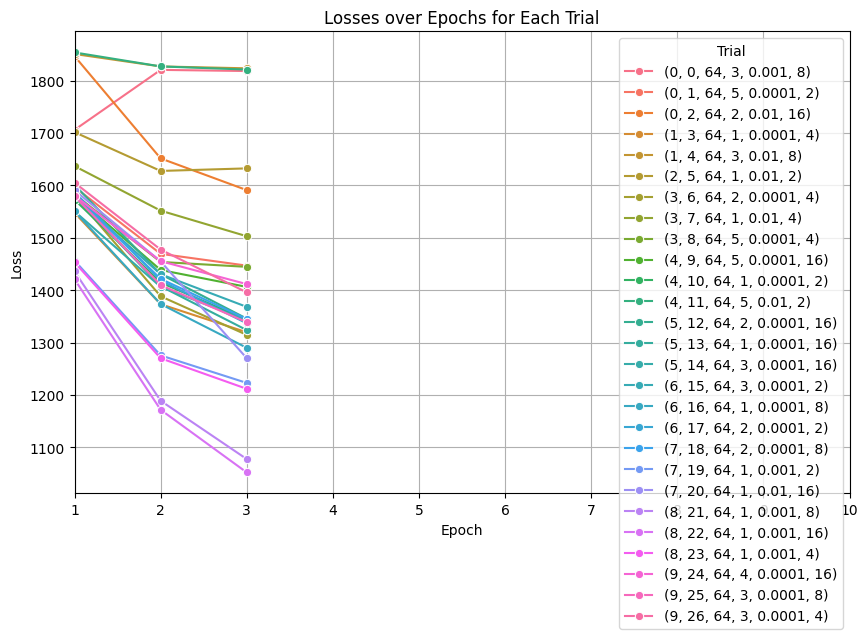

In [28]:
# Prepare data for plotting
plot_data = []
for trial_idx, trial_losses in losses.items():
    for epoch, loss_val in enumerate(trial_losses):
        plot_data.append({'Trial': trial_idx, 'Epoch': epoch + 1, 'Loss': loss_val})

df_losses = pd.DataFrame(plot_data)

# Plotting the losses
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_losses, x='Epoch', y='Loss', hue='Trial', marker='o')
plt.title('Losses over Epochs for Each Trial')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xlim(1, 10) # Set x-axis limit to 10 epochs
plt.show()

In [29]:
(best_parameters, loss, _, _) = client.get_best_parameterization()

print("Best Hyperparameters:")
for key, value in best_parameters.items():
    print(f"  {key}: {value}")

Best Hyperparameters:
  num_layers: 1
  learning_rate: 0.001
  num_heads: 16


In [30]:
embedding_dim = 64
hidden_size = 20
num_layers = 1
output_size = 3
vocabulary_size = len(vocab)
learning_rate = 0.01

num_layers = best_parameters["num_layers"]
learning_rate = best_parameters["learning_rate"]
num_heads = best_parameters["num_heads"]

dataset = TextDataset(X_train3, y_train3)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_batch)

model = SentimentTransformer(vocabulary_size, embedding_dim, num_heads, num_layers, output_size).to(device)
# Use BCEWithLogitsLoss to handle raw logits from the model
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (X, y) in enumerate(dataloader):
        # Truncate sequence length to max_len (512) to avoid position encoding mismatch
        if X.size(1) > 512:
            X = X[:, :512]

        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses[(i, trial_index, embedding_dim, num_layers, learning_rate, num_heads)].append(total_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}')

print("Training completed.")

# Set raw_data as a dictionary with metric names as keys and results as values
raw_data = {metric_name: total_loss}

Epoch [1/10], Loss: 1423.0135
Epoch [2/10], Loss: 1179.5493
Epoch [3/10], Loss: 1046.7288
Epoch [4/10], Loss: 933.0405
Epoch [5/10], Loss: 843.9951
Epoch [6/10], Loss: 746.7963
Epoch [7/10], Loss: 677.6406
Epoch [8/10], Loss: 587.3962
Epoch [9/10], Loss: 549.1244
Epoch [10/10], Loss: 481.8113
Training completed.


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# Re-generate the split to ensure X_test3 and y_test3 are fresh and aligned
X_train3, X_test3, y_train3, y_test3 = train_test_split(
    encoded, satisfied_3labels, test_size=0.2, random_state=42
)

# Create DataLoader for test data
test_dataset = TextDataset(X_test3, y_test3)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X, y in test_dataloader:
        # Truncate sequence length to max_len (512) to match training
        if X.size(1) > 512:
            X = X[:, :512]

        X = X.to(device)
        outputs = model(X)

        # Get predicted class indices (argmax of logits)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        # Get true class indices from one-hot encoded labels
        targets = torch.argmax(y, dim=1).numpy()

        all_preds.extend(preds)
        all_targets.extend(targets)

# Calculate metrics
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7981
Precision: 0.7848
Recall: 0.7981
F1 Score: 0.7882


In [32]:
from sklearn.metrics import classification_report

# Define class names for readability based on your satisfied_3labels logic
# 0 = Negative, 1 = Neutral, 2 = Positive
target_names = ['Negative', 'Neutral', 'Positive']

# Generate a detailed report to see metrics per class
report = classification_report(all_targets, all_preds, target_names=target_names)
print(report)

              precision    recall  f1-score   support

    Negative       0.60      0.41      0.49       297
     Neutral       0.29      0.29      0.29       196
    Positive       0.88      0.93      0.90      1647

    accuracy                           0.80      2140
   macro avg       0.59      0.54      0.56      2140
weighted avg       0.78      0.80      0.79      2140



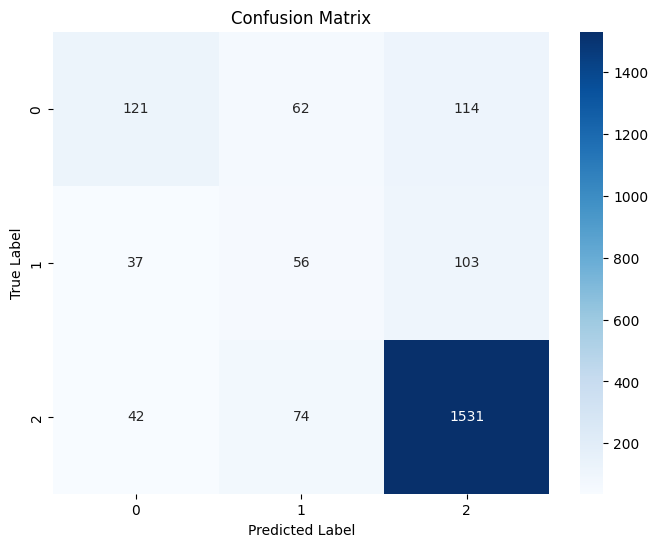

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()